In [162]:
import pandas as pd
import numpy as np

import matplotlib.pylab as plt 
import seaborn as sns
sns.set(palette='magma', color_codes=True,style='dark')

from statsmodels.stats.multicomp import pairwise_tukeyhsd

from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.model_selection  import train_test_split 

from google.cloud import bigquery
import os

In [2]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = r"G:\Downloads\diom-f00db-d53b3b55093e.json"

In [3]:
from google.cloud import bigquery

client = bigquery.Client()

# Perform a query.
QUERY = (
    'SELECT * FROM `diom-f00db.SalesData.Sales_tb`'
    'WHERE Order_ID IS NOT NULL'
)
query_job = client.query(QUERY)  # API request
    

In [43]:
df = client.query(QUERY).to_dataframe()
df.head(5)

,Order_ID,Product,Quantity_Ordered,Price_Each,Order_Date,Purchase_Address,State_Key
0,162037,iPhone,1,700.0,2019-03-23 02:11:00+00:00,"277 Elm St, Los Angeles, CA 90001",CA 90001
1,162084,iPhone,1,700.0,2019-03-27 12:53:00+00:00,"585 14th St, Los Angeles, CA 90001",CA 90001
2,162325,iPhone,1,700.0,2019-03-26 23:54:00+00:00,"789 6th St, Los Angeles, CA 90001",CA 90001
3,162338,iPhone,1,700.0,2019-03-22 00:42:00+00:00,"516 Madison St, Los Angeles, CA 90001",CA 90001
4,182018,iPhone,1,700.0,2019-04-21 15:37:00+00:00,"165 13th St, Los Angeles, CA 90001",CA 90001


In [44]:
# describtion 
df.describe()

,Order_ID,Quantity_Ordered,Price_Each
count,185950.0,185950.0,185950.000000
mean,230417.569379,1.124383,184.399735
std,51512.73711,0.442793,332.731330
min,141234.0,1.0,2.990000
25%,185831.25,1.0,11.950000
50%,230367.5,1.0,14.950000
75%,275035.75,1.0,150.000000
max,319670.0,9.0,1700.000000


In [45]:
# info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185950 entries, 0 to 185949
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype              
---  ------            --------------   -----              
 0   Order_ID          185950 non-null  Int64              
 1   Product           185950 non-null  object             
 2   Quantity_Ordered  185950 non-null  Int64              
 3   Price_Each        185950 non-null  float64            
 4   Order_Date        185950 non-null  datetime64[ns, UTC]
 5   Purchase_Address  185950 non-null  object             
 6   State_Key         185950 non-null  object             
dtypes: Int64(2), datetime64[ns, UTC](1), float64(1), object(3)
memory usage: 10.3+ MB


In [46]:
#check for na 
df.isna().sum()

Order_ID            0
Product             0
Quantity_Ordered    0
Price_Each          0
Order_Date          0
Purchase_Address    0
State_Key           0
dtype: int64

## EDA

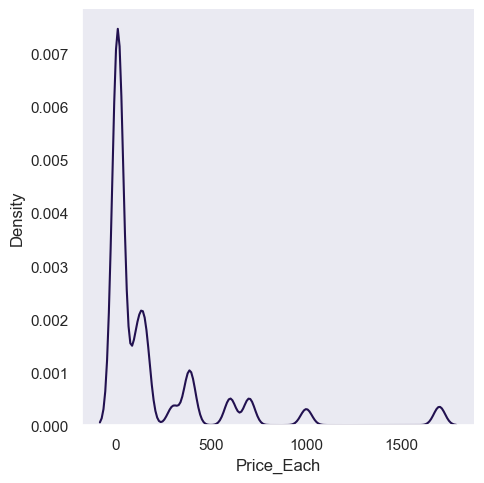

In [47]:
# distribution
sns.displot(df['Price_Each'], kind='kde',)

Quantity_Ordered
1    168552
2     13324
3      2920
4       806
5       236
6        80
7        24
8         5
9         3
Name: count, dtype: Int64


<AxesSubplot:xlabel='Quantity_Ordered'>

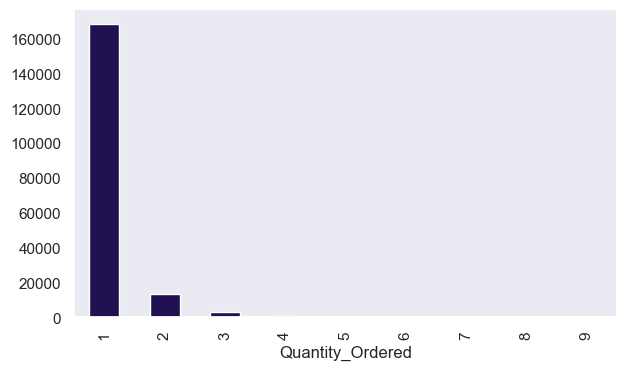

In [48]:
# Quantity_Ordered distribution
q1 = df['Quantity_Ordered'].value_counts()
print(q1)
plt.figure(figsize=(7,4))
q1.plot.bar()

,Order_ID,Quantity_Ordered,Price_Each
Order_ID,1.000000,0.000702,-0.002857
Quantity_Ordered,0.000702,1.000000,-0.148272
Price_Each,-0.002857,-0.148272,1.000000


<AxesSubplot:>

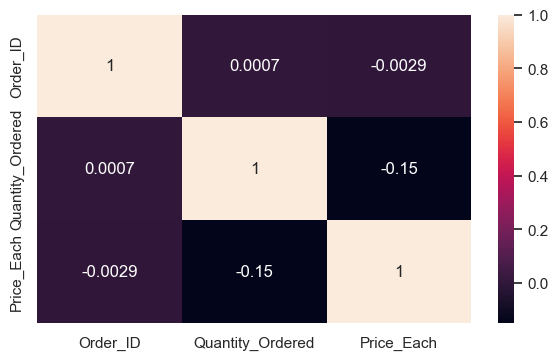

In [49]:
# calculate the corr and vis it
correlation = df.corr(numeric_only=True)
display(correlation)
plt.figure(figsize=(7,4))
sns.heatmap(correlation, annot=True)

## Feature Engineering

In [50]:
df.head(2)

,Order_ID,Product,Quantity_Ordered,Price_Each,Order_Date,Purchase_Address,State_Key
0,162037,iPhone,1,700.0,2019-03-23 02:11:00+00:00,"277 Elm St, Los Angeles, CA 90001",CA 90001
1,162084,iPhone,1,700.0,2019-03-27 12:53:00+00:00,"585 14th St, Los Angeles, CA 90001",CA 90001


In [51]:
# add the state unique key
df['SKey'] = df['State_Key'].apply(lambda x: x.split(" ")[0])
df.head(2)

,Order_ID,Product,Quantity_Ordered,Price_Each,Order_Date,Purchase_Address,State_Key,SKey
0,162037,iPhone,1,700.0,2019-03-23 02:11:00+00:00,"277 Elm St, Los Angeles, CA 90001",CA 90001,CA
1,162084,iPhone,1,700.0,2019-03-27 12:53:00+00:00,"585 14th St, Los Angeles, CA 90001",CA 90001,CA


In [52]:
# Add Postal code
df['Postal Key'] = df['State_Key'].apply(lambda x: x.split(" ")[1])
df.head(2)

,Order_ID,Product,Quantity_Ordered,Price_Each,Order_Date,Purchase_Address,State_Key,SKey,Postal Key
0,162037,iPhone,1,700.0,2019-03-23 02:11:00+00:00,"277 Elm St, Los Angeles, CA 90001",CA 90001,CA,90001
1,162084,iPhone,1,700.0,2019-03-27 12:53:00+00:00,"585 14th St, Los Angeles, CA 90001",CA 90001,CA,90001


In [54]:
# Add State Name
df['State Name'] = df['Purchase_Address'].apply(lambda x: x.split(",")[1].split(",")[0])
df.head(2)

,Order_ID,Product,Quantity_Ordered,Price_Each,Order_Date,Purchase_Address,State_Key,SKey,Postal Key,State Name
0,162037,iPhone,1,700.0,2019-03-23 02:11:00+00:00,"277 Elm St, Los Angeles, CA 90001",CA 90001,CA,90001,Los Angeles
1,162084,iPhone,1,700.0,2019-03-27 12:53:00+00:00,"585 14th St, Los Angeles, CA 90001",CA 90001,CA,90001,Los Angeles


In [88]:
# add month & year & quarter
df['Month'] = df['Order_Date'].dt.month
df['Year'] = df['Order_Date'].dt.year
df['Quarter'] = df['Order_Date'].dt.quarter
df.head(2)

,Order_ID,Product,Quantity_Ordered,Price_Each,Order_Date,Purchase_Address,State_Key,SKey,Postal Key,State Name,Month,Year,Quarter
0,162037,iPhone,1,700.0,2019-03-23 02:11:00+00:00,"277 Elm St, Los Angeles, CA 90001",CA 90001,CA,90001,Los Angeles,3,2019,1
1,162084,iPhone,1,700.0,2019-03-27 12:53:00+00:00,"585 14th St, Los Angeles, CA 90001",CA 90001,CA,90001,Los Angeles,3,2019,1


In [90]:
# add total sales
df['Total Sales'] = df['Quantity_Ordered'] * df['Price_Each']
df.head(2)

,Order_ID,Product,Quantity_Ordered,Price_Each,Order_Date,Purchase_Address,State_Key,SKey,Postal Key,State Name,Month,Year,Quarter,Total Sales
0,162037,iPhone,1,700.0,2019-03-23 02:11:00+00:00,"277 Elm St, Los Angeles, CA 90001",CA 90001,CA,90001,Los Angeles,3,2019,1,700.0
1,162084,iPhone,1,700.0,2019-03-27 12:53:00+00:00,"585 14th St, Los Angeles, CA 90001",CA 90001,CA,90001,Los Angeles,3,2019,1,700.0


## Data Analysis

### Q1:) Highest Top Ordered Products & the Lowest Ones ?

Product
AAA Batteries (4-pack)        31017
AA Batteries (4-pack)         27635
USB-C Charging Cable          23975
Lightning Charging Cable      23217
Wired Headphones              20557
Apple Airpods Headphones      15661
Bose SoundSport Headphones    13457
27in FHD Monitor               7550
iPhone                         6849
27in 4K Gaming Monitor         6244
Name: Quantity_Ordered, dtype: Int64


<AxesSubplot:title={'center':'Highest Top Products'}, xlabel='Product'>

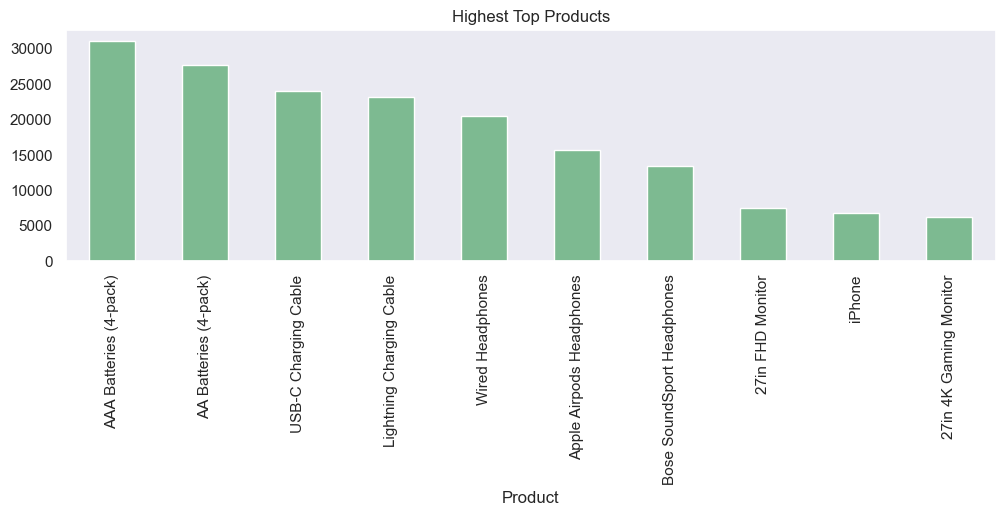

In [80]:
q1 = df.groupby('Product')['Quantity_Ordered'].sum().nlargest(10)
print(q1)
plt.figure(figsize=(12,3))
sns.set_palette('crest')
plt.title("Highest Top Products")
q1.plot.bar()

Product
LG Dryer                   646
LG Washing Machine         666
Vareebadd Phone           2068
20in Monitor              4129
ThinkPad Laptop           4130
Macbook Pro Laptop        4728
Flatscreen TV             4819
Google Phone              5532
34in Ultrawide Monitor    6199
27in 4K Gaming Monitor    6244
Name: Quantity_Ordered, dtype: Int64


<AxesSubplot:title={'center':'Lowest Products'}, xlabel='Product'>

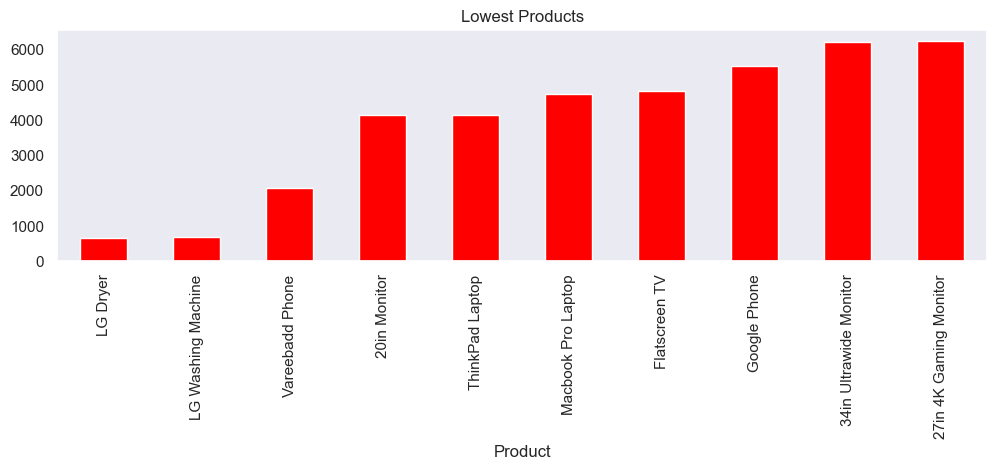

In [83]:
q1_2 = df.groupby('Product')['Quantity_Ordered'].sum().nsmallest(10)
print(q1_2)
plt.figure(figsize=(12,3))
plt.title("Lowest Products")
q1_2.plot.bar(color='red')

### Q2:) Highest Top 5 Months with Total Sales in 2019?

In [91]:
df.head(5)

,Order_ID,Product,Quantity_Ordered,Price_Each,Order_Date,Purchase_Address,State_Key,SKey,Postal Key,State Name,Month,Year,Quarter,Total Sales
0,162037,iPhone,1,700.0,2019-03-23 02:11:00+00:00,"277 Elm St, Los Angeles, CA 90001",CA 90001,CA,90001,Los Angeles,3,2019,1,700.0
1,162084,iPhone,1,700.0,2019-03-27 12:53:00+00:00,"585 14th St, Los Angeles, CA 90001",CA 90001,CA,90001,Los Angeles,3,2019,1,700.0
2,162325,iPhone,1,700.0,2019-03-26 23:54:00+00:00,"789 6th St, Los Angeles, CA 90001",CA 90001,CA,90001,Los Angeles,3,2019,1,700.0
3,162338,iPhone,1,700.0,2019-03-22 00:42:00+00:00,"516 Madison St, Los Angeles, CA 90001",CA 90001,CA,90001,Los Angeles,3,2019,1,700.0
4,182018,iPhone,1,700.0,2019-04-21 15:37:00+00:00,"165 13th St, Los Angeles, CA 90001",CA 90001,CA,90001,Los Angeles,4,2019,2,700.0


Month
12    4613443.34
10    3736726.88
4     3390670.24
11     3199603.2
5     3152606.75
3     2807100.38
7     2647775.76
6     2577802.26
8     2244467.88
2     2202022.42
9     2097560.13
1     1813586.44
Name: Total Sales, dtype: Float64


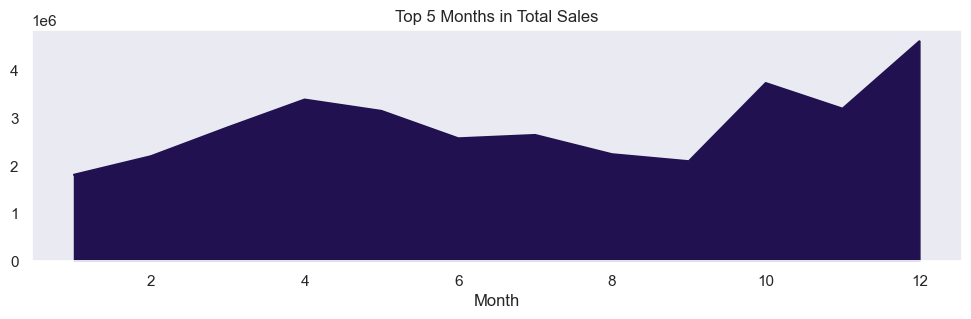

In [107]:
q2=df[df['Year'] == 2019].groupby('Month')['Total Sales'].sum()
plt.figure(figsize=(12,3))
sns.set_palette('magma')
plt.title("Top 5 Months in Total Sales")
q2.plot.area()
print(q2.sort_values(ascending=False))

**12,10,4,11,5** Months are the Hightest Sales 

### Q3:) Highest Top 10 States with Total Sales ?

State Name
 San Francisco    8262203.91
 Los Angeles       5452570.8
 New York City    4664317.43
 Boston           3661642.01
 Atlanta          2795498.58
 Dallas            2767975.4
 Seattle          2747755.48
 Portland         2320490.61
 Austin           1819581.75
Name: Total Sales, dtype: Float64


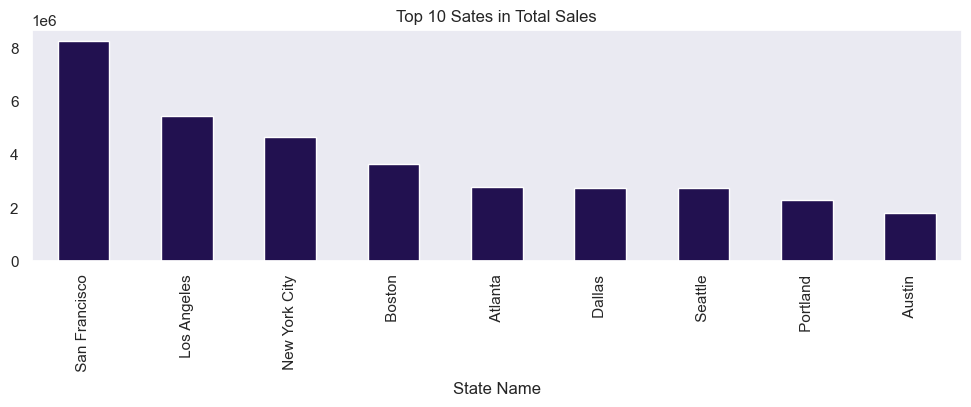

In [106]:
q3=df.groupby('State Name')['Total Sales'].sum().nlargest(10)
plt.figure(figsize=(12,3))
sns.set_palette('magma')
plt.title("Top 10 Sates in Total Sales")
q3.plot.bar()
print(q3)

### Q4) Are the Iphone and Google Phones are nearly Equal in Quantity Orders?

group1,group2,meandiff,p-adj,lower,upper,reject
Google Phone,iPhone,-0.0002,0.6885,-0.0014,0.0009,False


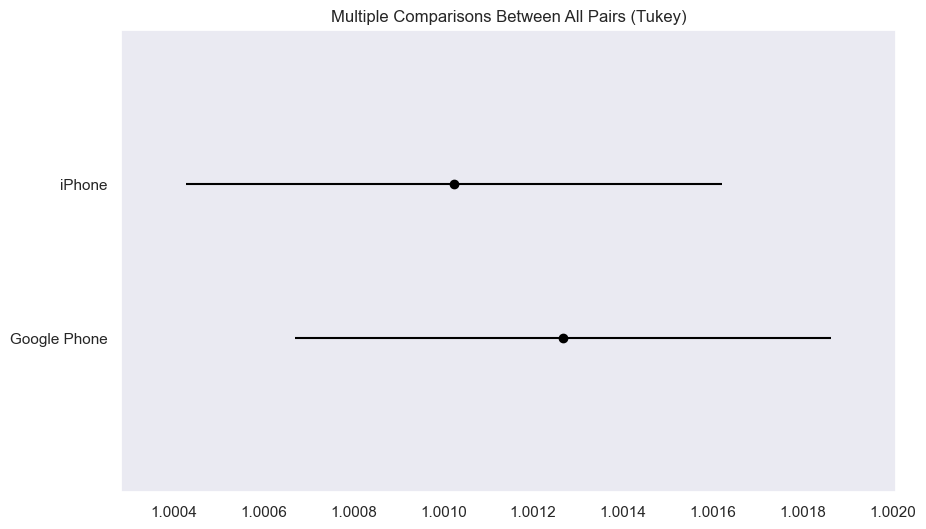

In [155]:
# using hypothesis test
test_data = df[df['Product'].isin(['iPhone','Google Phone'])][['Product','Quantity_Ordered']]

test_data['Product']=test_data['Product'].astype('str')
test_data['Quantity_Ordered'] = test_data['Quantity_Ordered'].astype(float)

tukey = pairwise_tukeyhsd(endog=np.array(test_data['Quantity_Ordered'].values),     # Data
                          groups=np.array(test_data['Product'].values),   # Groups
                          alpha=0.05)          # Significance level
tukey.plot_simultaneous()    # Plot group confidence intervals

tukey.summary()     

**Accept the Null Hypothesis means there is no significant difference between 'em**

### Check the Patterns in the data

In [213]:
df.columns

Index(['Order_ID', 'Product', 'Quantity_Ordered', 'Price_Each', 'Order_Date',
       'Purchase_Address', 'State_Key', 'SKey', 'Postal Key', 'State Name',
       'Month', 'Year', 'Quarter', 'Total Sales'],
      dtype='object')

In [214]:
new_df=df.drop(['Order_ID','Order_Date','Purchase_Address','State_Key','State Name'],axis=1)
new_df.head(2)

,Product,Quantity_Ordered,Price_Each,SKey,Postal Key,Month,Year,Quarter,Total Sales
0,iPhone,1,700.0,CA,90001,3,2019,1,700.0
1,iPhone,1,700.0,CA,90001,3,2019,1,700.0


In [215]:
new_df['Postal Key'] = new_df['Postal Key'].apply(lambda x:x.replace('\"',''))
idx = new_df[new_df['Postal Key'].isna()].index
new_df.drop(idx,inplace=True)

In [216]:
transformation_cols = ['SKey', 'SKey','Product']
label_endcoder = LabelEncoder()
#new_df['Postal Key'] = new_df['Postal Key'].astype(int)
for feature in transformation_cols:
    new_df[feature] = label_endcoder.fit_transform(new_df[feature])
new_df.head(2)    

,Product,Quantity_Ordered,Price_Each,SKey,Postal Key,Month,Year,Quarter,Total Sales
0,18,1,700.0,0,90001,3,2019,1,700.0
1,18,1,700.0,0,90001,3,2019,1,700.0


In [219]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(new_df)
kmeans.cluster_centers_

array([[9.11981463e+00, 1.12335468e+00, 1.85046150e+02, 2.60061790e+00,
        1.21313652e+04, 7.06064751e+00, 2.01900023e+03, 2.68174943e+00,
        1.86194064e+02],
       [9.14231366e+00, 1.12489903e+00, 1.84075253e+02, 2.43549481e+00,
        8.98525801e+04, 7.05838260e+00, 2.01900016e+03, 2.68130270e+00,
        1.85137957e+02]])

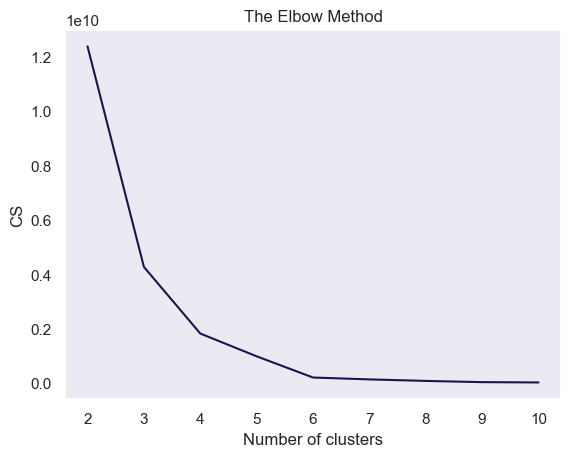

In [227]:
cs = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(new_df)
    cs.append(kmeans.inertia_)
plt.plot(range(2, 11), cs)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('CS')
plt.show()

4 is the optimizal number for clustering

In [228]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(new_df)
kmeans.cluster_centers_

array([[8.99915271e+00, 1.15903993e+00, 4.28596386e+01, 2.48510650e+00,
        7.06709540e+00, 2.01900017e+03, 2.68397586e+00, 4.38496869e+01],
       [1.37077915e+01, 1.00274664e+00, 7.30440494e+02, 2.48256726e+00,
        6.96900224e+00, 2.01900028e+03, 2.65336323e+00, 7.31707293e+02],
       [1.30004232e+01, 1.00126957e+00, 1.69970376e+03, 2.49978840e+00,
        7.10093102e+00, 2.01900021e+03, 2.69445620e+00, 1.70156580e+03],
       [4.99350348e+00, 1.00897138e+00, 3.63699705e+02, 2.53730343e+00,
        7.07280227e+00, 2.01900015e+03, 2.68538283e+00, 3.65192336e+02]])

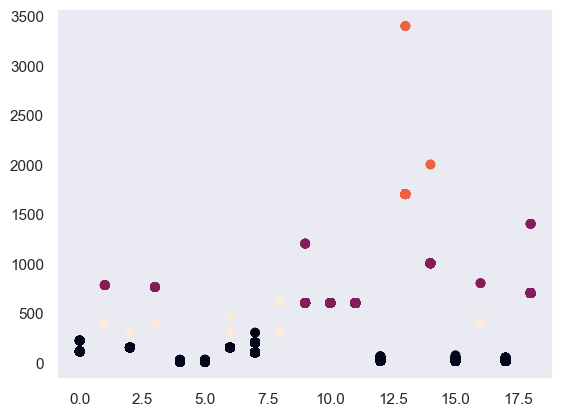

In [235]:
new_df['Clusters'] = kmeans.labels_
plt.scatter(new_df["Product"], 
            new_df["Total Sales"], 
            c = new_df["Clusters"])